In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [2]:
# Обучить полносвязную модель на MNIST
# Обучить глубокую сверточную сеть на MNIST
# *обучить с нуля глубокую сеть на небольшом датасете. Сравнить результат с дообучением предобученной сети

In [3]:
# архитектура модели + 
# загрузчик данных +
# формирование батча +
# инициализировать модель +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [4]:
dataset = datasets.MNIST('.', download=True)


In [5]:
torch.backends.mps.is_available()

True

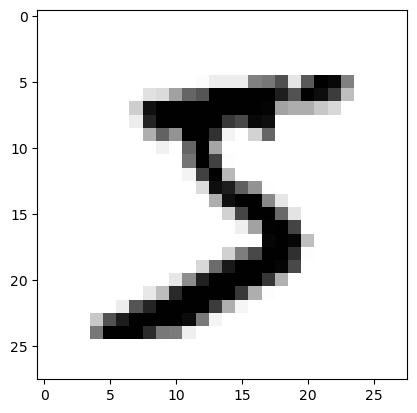

In [7]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy(), cmap='binary')
plt.show()

In [8]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        nn.init.kaiming_normal_(self.linear1.weight, nonlinearity='relu')
        # custom initsialisation nn.init.xavier_normal_(self.linear1.weight)
        self.do1 = nn.Dropout(dropout_p)
        
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        nn.init.kaiming_normal_(self.linear2.weight, nonlinearity='relu')
        self.do2 = nn.Dropout(dropout_p)
        
        self.linear3 = nn.Linear(hidden_dim2, output_dim)
        nn.init.kaiming_normal_(self.linear3.weight, nonlinearity='relu')
        
        self.activation = nn.ReLU()
        

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        
        x = self.linear2(x)
        x = self.activation(x)
        x = self.do2(x)
        
        x = self.linear3(x)

        return x

In [9]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

In [10]:
train, test = random_split(dataset, lengths=[0.9, 0.1])

In [11]:
# Как формируется батча
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset

def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(np.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(np.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(np.array(target))

  return {
      'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
      'target': target,
      }


In [12]:
# hyperparams
inp_dim = 28 * 28
hidden1 = 256
hidden2 = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else 'mps' # 'cuda:1' id GPU
n_epochs = 10
batch_size = 128

In [13]:
model = LinearModel(inp_dim, hidden1, hidden2, out_dim).to(device)
model.train() # переводит модель в режим обучения
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [14]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')


epoch: 0, step: 0, loss: 2.382016658782959
epoch: 0, step: 200, loss: 0.18898145854473114
epoch: 0, step: 400, loss: 0.1347602754831314
epoch: 1, step: 0, loss: 0.11046909540891647
epoch: 1, step: 200, loss: 0.09931308776140213
epoch: 1, step: 400, loss: 0.1335953325033188
epoch: 2, step: 0, loss: 0.10864026099443436
epoch: 2, step: 200, loss: 0.09692856669425964
epoch: 2, step: 400, loss: 0.141458198428154
epoch: 3, step: 0, loss: 0.09717009216547012
epoch: 3, step: 200, loss: 0.044383276253938675
epoch: 3, step: 400, loss: 0.05706971138715744
epoch: 4, step: 0, loss: 0.025116128847002983
epoch: 4, step: 200, loss: 0.06964713335037231
epoch: 4, step: 400, loss: 0.02775159291923046
epoch: 5, step: 0, loss: 0.04117473214864731
epoch: 5, step: 200, loss: 0.05106509104371071
epoch: 5, step: 400, loss: 0.047629617154598236
epoch: 6, step: 0, loss: 0.009802951477468014
epoch: 6, step: 200, loss: 0.06489723920822144
epoch: 6, step: 400, loss: 0.06471839547157288
epoch: 7, step: 0, loss: 0.02

In [15]:
model.eval()
dataloader = DataLoader(dataset, 
                            batch_size=60000,
                            collate_fn=collate_fn,
                            drop_last = True,
                            )
for i, batch in enumerate(dataloader):
    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    print(loss.item())

0.010701805353164673


In [16]:
# если тест входил в трейнинг, результат выше.
# но он слишком завышен.

In [17]:
# hyperparams
inp_dim = 28 * 28
hidden1 = 256
hidden2 = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else 'mps' # 'cuda:1' id GPU
n_epochs = 4
batch_size = 128

In [18]:
model = LinearModel(inp_dim, hidden1, hidden2, out_dim).to(device)
model.train() # переводит модель в режим обучения
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [19]:
%%time
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            sampler=np.random.choice(train.indices, 50000, replace = False), 
                            collate_fn=collate_fn,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')


epoch: 0, step: 0, loss: 2.4226479530334473
epoch: 0, step: 200, loss: 0.19027964770793915
epoch: 1, step: 0, loss: 0.08903768658638
epoch: 1, step: 200, loss: 0.1425144374370575
epoch: 2, step: 0, loss: 0.1479475200176239
epoch: 2, step: 200, loss: 0.027470797300338745
epoch: 3, step: 0, loss: 0.14788836240768433
epoch: 3, step: 200, loss: 0.054858993738889694
CPU times: user 53.9 s, sys: 1min 49s, total: 2min 43s
Wall time: 37.7 s


In [20]:
model.eval()
dataloader = DataLoader(dataset, 
                            batch_size=6000,
                            collate_fn=collate_fn,
                            sampler=test.indices,
                            drop_last = True,
                            )
for batch in dataloader:
    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    print(loss.item())
# 128 нейронов

0.08025053143501282


# Сверточная сеть

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [2]:
dataset = datasets.MNIST('.', download=True)
train, test = random_split(dataset, lengths=[0.9, 0.1])

In [3]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1) 
    self.classifier = nn.Linear(5 * 14 *14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.do2(x)
    x = self.conv3(x)
    x = self.classifier(x.view(x.size(0), -1))

    return x

In [4]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else 'mps'
n_epochs = 5
batch_size = 128

In [5]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(np.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(np.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(np.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [6]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()
model_conv.train();

In [16]:
%%time
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                          batch_size, 
                          sampler=np.random.choice(train.indices, 54000, replace = False),
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3015706539154053
epoch: 0, step: 200, loss: 0.13318786025047302
epoch: 0, step: 400, loss: 0.04441331326961517
epoch: 1, step: 0, loss: 0.12791942059993744
epoch: 1, step: 200, loss: 0.05582672730088234
epoch: 1, step: 400, loss: 0.03451932966709137
epoch: 2, step: 0, loss: 0.03608793020248413
epoch: 2, step: 200, loss: 0.0645371600985527
epoch: 2, step: 400, loss: 0.07481744140386581
epoch: 3, step: 0, loss: 0.05349782854318619
epoch: 3, step: 200, loss: 0.0602298341691494
epoch: 3, step: 400, loss: 0.02760174870491028
epoch: 4, step: 0, loss: 0.026368342339992523
epoch: 4, step: 200, loss: 0.0513472855091095
epoch: 4, step: 400, loss: 0.010437138378620148
CPU times: user 4min 27s, sys: 9min 31s, total: 13min 59s
Wall time: 2min 56s


In [26]:
dataloader = DataLoader(dataset, 
                            6000, 
                            sampler=test.indices, 
                            collate_fn=collate_fn_conv,
                            drop_last = True,
                            )
model_conv.eval()
for batch in dataloader:
        

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        print(f'loss: {loss.item()}')


loss: 0.04089317470788956


In [ ]:
#Теперь попробую с пуллингом

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

dataset = datasets.MNIST('.', download=True)
train, test = random_split(dataset, lengths=[0.9, 0.1])

# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else 'mps'
n_epochs = 5
batch_size = 128

def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(np.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(np.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(np.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [11]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else 'mps'
n_epochs = 7
batch_size = 128

In [12]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, padding=1, stride=1) 
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.pool = nn.MaxPool2d(kernel_size=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1) 
    self.classifier = nn.Linear(5 * 14 * 14, output_dim) 
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    
    self.activation = nn.ReLU()

  def forward(self, x):
    
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.pool(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.do2(x)
    x = self.conv3(x)
    x = self.classifier(x.view(x.size(0), -1))

    return x

In [13]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [14]:
%%time
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                          batch_size, 
                          sampler=np.random.choice(train.indices, 54000, replace = False),
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3624000549316406
epoch: 0, step: 200, loss: 0.09877605736255646
epoch: 0, step: 400, loss: 0.06001133844256401
epoch: 1, step: 0, loss: 0.11436747014522552
epoch: 1, step: 200, loss: 0.0070196883752942085
epoch: 1, step: 400, loss: 0.06372366100549698
epoch: 2, step: 0, loss: 0.0756649523973465
epoch: 2, step: 200, loss: 0.011324637569487095
epoch: 2, step: 400, loss: 0.004096990916877985
epoch: 3, step: 0, loss: 0.09800150245428085
epoch: 3, step: 200, loss: 0.039686769247055054
epoch: 3, step: 400, loss: 0.060805149376392365
epoch: 4, step: 0, loss: 0.04872618615627289
epoch: 4, step: 200, loss: 0.03962675854563713
epoch: 4, step: 400, loss: 0.008305718190968037
epoch: 5, step: 0, loss: 0.08625485002994537
epoch: 5, step: 200, loss: 0.003557687858119607
epoch: 5, step: 400, loss: 0.038306474685668945
epoch: 6, step: 0, loss: 0.011951133608818054
epoch: 6, step: 200, loss: 0.07363460212945938
epoch: 6, step: 400, loss: 0.07146801799535751
CPU times: user 7mi

In [15]:
dataloader = DataLoader(dataset, 
                            6000, 
                            sampler=test.indices, 
                            collate_fn=collate_fn_conv,
                            drop_last = True,
                            )
model_conv.eval()
for batch in dataloader:
        

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        print(f'loss: {loss.item()}')


loss: 0.04840213060379028


In [16]:
# С пулингом подружил, добавил эпох и поставил дропаут после пулинга. Пробовал его в разные места втыкать, 
# дополнительно сверткой снижать размерность до 7х7
# Но в итоге выходит результат хуже. 
# Если размерность не поймать, то крашится едро и приходится собирать всё заново. 
# Поэтому повсюду оставил импорты и дубли кода, чтобы проще былоэкспериментировать.